Optimization terminated successfully.
         Current function value: 3.761884
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
6.14181280136 0.0566363140801 -0.0666661059781


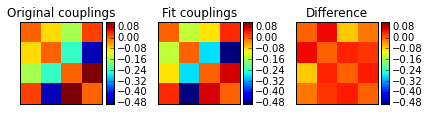

In [679]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib
import matplotlib.pyplot as plt
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import optimize

%matplotlib inline

t1 = time.time()

#Varibales
seed = 89
dim = 4
nsamples = 500
rng = np.random.RandomState(seed)

#Generating the original coupling matrix
J = rng.randn(dim, dim)/(np.sqrt(dim) * 1)
np.fill_diagonal(J, 0.)

J_orig = (J + J.T) / 2.
b_orig = -J_orig.sum(axis = 0)

#Generating a sample of size dim*nsamples using Gibbs sampling method
n_burn_in = dim * 100000
sample_space = dim * 10
total_samples = n_burn_in + sample_space * (nsamples - 1)

units = rng.randint(dim, size=total_samples)
state = rng.choice([0, 1, 2], size = dim, p = [0.3,0.3,0.4])

samples = np.zeros((nsamples, dim))
sample_idx = 0

for i in xrange(total_samples):
    j = units[i]
    E_acc = 2*state.dot(J_orig[j,:]) + b_orig[j]
    val = 1./(1. + np.exp(-E_acc) + np.exp(- 2 * E_acc))
    dumm = rng.uniform(size=val.shape)

    if dumm < val * np.exp(-2 * E_acc):
        state[j] = 2
        state_new = state
    elif dumm < val * (np.exp(-2 * E_acc) + np.exp(-E_acc)):
        state[j] = 1
        state_new = state    
    else:
        state[j] = 0
        state_new = state
    if (i >= n_burn_in) and ((i - n_burn_in) % sample_space == 0):
        samples[sample_idx] = state_new
        sample_idx += 1
                
            
samples = samples - 1            
#Fitting a Potts model to the generated samples using MPF
J = T.dvector('J')
X = T.dmatrix('X')

J_rav = T.reshape(J, (dim, dim))
b = T.identity_like(J_rav)
diag = T.reshape(b, (1, dim**2))

dummy = T.tile(X, (1, dim))
dummy1 = T.repeat(X, dim, axis=1)

dummy2 = dummy1 + 1
idxs = (T.eq(dummy2, 2)).nonzero()
dummy2 = T.set_subtensor(dummy2[idxs], -1)

dummy3 = dummy1 - 1
idxs = (T.eq(dummy3, -2)).nonzero()
dummy3 = T.set_subtensor(dummy3[idxs], 1)

Kfull = (T.switch(T.eq(dummy, dummy1), 1 , 0) - T.switch(T.eq(dummy, dummy2), 1 , 0)) * J - diag * J
#Kfull += (T.switch(T.eq(dummy, dummy1), 1 , 0) - T.switch(T.eq(dummy, dummy3), 1 , 0)) * J - diag * J 

K = T.exp(T.reshape(Kfull, (dim*nsamples, dim)).sum(axis = 1)).mean() * dim - 0.05 * (J - diag * J).sum()
#K += - 0.05 * 0.5 * ((J - diag * J)**2).sum()
dK = T.grad(K, J)


f = theano.function([J, X], [K, dK])


init_vec = np.zeros(dim**2)
res = optimize.minimize(f, init_vec, args=(samples,), jac=True,options={'maxiter':1e+5,'disp':True})
 

J_fit = res.x.reshape(dim, dim)
np.fill_diagonal(J_fit, 0)
J_fit = (J_fit + J_fit.T)/2.


#Plotting   
J_diff = (J_orig - J_fit)
minJ = np.min([J_fit.min(), J_orig.min(), J_diff.min()])
maxJ = np.max([J_fit.max(), J_orig.max(), J_diff.max()])
fig, axes = plt.subplots(nrows=1, ncols=3)
plt.tight_layout(pad=0.4, w_pad=1.5, h_pad=2.0)


ax = axes[0]
ax.set_yticks([])
ax.set_xticks([10, 20, 30, 40])
im = ax.imshow(J_orig, vmin=minJ, vmax=maxJ, interpolation='nearest')
ax.set_title('Original couplings')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(im, cax=cax)

ax = axes[1]
ax.set_yticks([])
ax.set_xticks([10, 20, 30, 40])
im = ax.imshow(J_fit, vmin=minJ, vmax=maxJ, interpolation='nearest')
ax.set_title('Fit couplings')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(im, cax=cax)

ax = axes[2]
ax.set_yticks([])
ax.set_xticks([10, 20, 30, 40])
im = ax.imshow(J_diff, vmin=minJ, vmax=maxJ, interpolation='nearest')
ax.set_title('Difference')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.tight_layout()

t2 = time.time()

print t2 - t1, J_diff.max(), J_diff.min()
plt.show()